In [18]:
#!import "setup.ipynb"

using PdfLexer.Content;
using PdfLexer.Content.Model;
using PdfLexer.Writing;


## PDF Text Redaction

This demonstrates the current redaction functionality of pdflexer. It is currently implemented using the `SinglePassRedactor` class in the `Pdflexer.Content` namespace. More user friendly redaction capabilities are planned.

We will first create a pdf page with some text content on it.


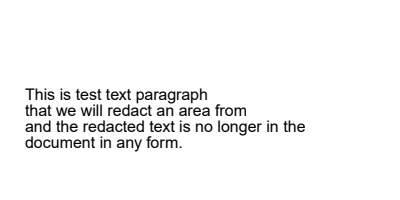

In [19]:
var doc = PdfDocument.Create();
var pg = doc.AddPage(400, 200);
{
    using var writer = pg.GetWriter();
    writer.Font(Base14.Helvetica, 16)
        .TextMove(25, 100)
        .Text("This is test text paragraph")
        .NewLine()
        .Text("that we will redact an area from")
        .NewLine()
        .Text("and the redacted text is no longer in the ")
        .NewLine()
        .Text("document in any form.");
}
display(pg);

Next we determine the areas of the page we want to redact using the `SimpleWordScanner` (from `PdfPage.GetWordScanner()`) and matching on words containing "text". In a real redaction scenario that should match on words it is advisable to use the `TextScanner` (from `PdfPage.GetTextScanner()`) and build the returned characters into words using a more robust method than the `SimpleWordScanner` as the simple word scanner may sometimes return partial words that may result in missed words in the document. More advanced character to word helpers are planned but for now this would need to be manually implemented.

In [20]:
// performance enhancement, this should be disposed but leaving so 
// caching persists between notebook sections
var cache = new StreamContentsCache();

var areas = new List<PdfRect<double>>();

void FindWords() // wrap in function due to polyglot notebook / ref struct
{
    var scanner = pg.GetWordScanner();
    while (scanner.Advance()) 
    {
        if (scanner.CurrentWord.Contains("text")) 
        {
            var bbox = scanner.GetWordBoundingBox();
            areas.Add(bbox);
        }
    }
}
FindWords();

display(areas);


index value 0 [106.13599970245362 99.888 130.88799956512452 110.70400000000001] LLx 106.13599970245362 LLy 99.888 URx 130.88799956512452 URy 110.70400000000001 1 [149.75199892425536 67.888 174.50399878692627 78.70400000000001] LLx 149.75199892425536 LLy 67.888 URx 174.50399878692627 URy 78.70400000000001

Next we use the `SinglePassRedactor` to remove characters that intersect the page areas we determined previously. We are enabling spacing randomization on the `SinglePassRedactor` to add some random spacing to each removed character.

Once completed the document is displayed and actual content stream showing the text has been completely removed from the pdf page and replaced with extra space.


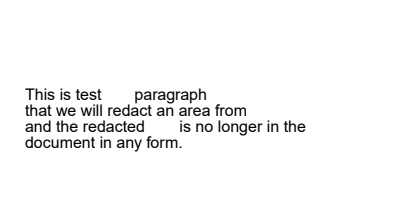

/F1 16 Tf
16 TL
BT
1 0 0 1 25 100 Tm
[(This is test ) -814.8699104785919 30 -731.1156094074249 ( par) 10 (ag) 10 (r) 10 (aph) ]TJ
T*
[(that w)10(e will redact an area from)] TJ

T*
[(and the redacted ) -891.5582597255707 30 -743.7138855457306 ( is no longer in the ) ]TJ
T*
[(document in an)15(y f)30(or)-25(m.)] TJ

ET


In [21]:
void Redact() // wrap in function due to polyglot notebook / ref struct
{
    var redaction = new SinglePassRedactor(pg, true); // randomize spacing to prevent reconstruction attempts in non monospace fonts
    pg = redaction.RedactContent(c => areas.Any(a => c.BoundingBox.Intersects(a)));
}

Redact();

display(pg);
display(pg.DumpDecodedContents());